In [1]:
# load training loss
from matplotlib import pyplot as plt
from tifffile import imread
import numpy as np
import pickle
from hydra.experimental import compose, initialize
from omegaconf import OmegaConf
import os

def read_pickle(file_name):
    with open(file_name, 'rb') as f:
        return pickle.load(f)

def tif_to_np(f_name):
    '''
    convert tif to numpy
    '''
    img = imread(f_name)
    img = img.astype('float32')/255
    return img>0.5


# initialize configuration parameters for a specific experiment
experiment = 'ex5'
initialize(config_path=f"../config/{experiment}")
cfg = compose(config_name="vqgan")


/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/hydra/experimental/initialize.py:43: UserWarning: hydra.experimental.initialize() is no longer experimental. Use hydra.initialize()
  deprecation_warning(message=message)
/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/hydra/experimental/initialize.py:45: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  self.delegate = real_initialize(
/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/hydra/experimental/compose.py:25: UserWarning: hydra.experimental.compose() is no longer experimental. Use hydra.compose()
  deprecation_warning(message=message)


In [22]:
root_path = os.path.join(cfg.checkpoints.PATH, cfg.experiment)
epoch = -1
path_train_loss = os.path.join(root_path,f'training_losses_epoch_{epoch}.pkl')
train_loss = read_pickle(path_train_loss)

FileNotFoundError: [Errno 2] No such file or directory: '/journel/s0/zur74/LatentPoreUpscale3DNet/lpu3dnet/train/checkpoints/ex5/training_losses_epoch_-1.pkl'

In [3]:
training_hours = train_loss['time'][-1].seconds /(60*60)
print('Total training time: {:.2f} hours'.format(training_hours))

Total training time: 0.19 hours


In [8]:
train_loss['rec_loss'][:10]

[0.15369191765785217,
 0.162924125790596,
 0.14173009991645813,
 0.1514866054058075,
 0.14552035927772522,
 0.14200454950332642,
 0.1747061312198639,
 0.14526058733463287,
 0.11805079132318497,
 0.16133294999599457]

#### Plot current training history

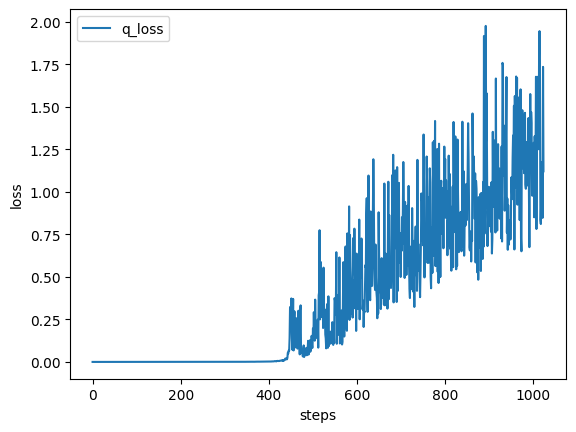

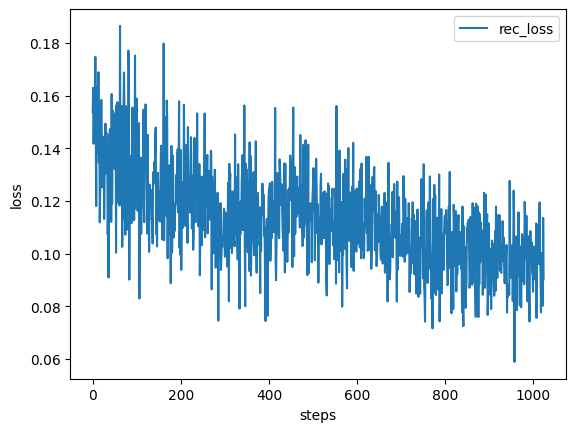

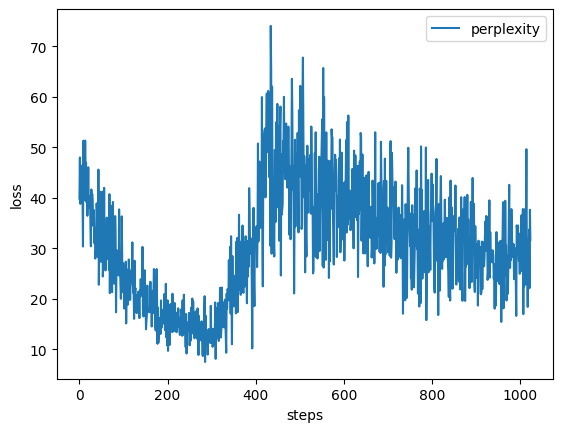

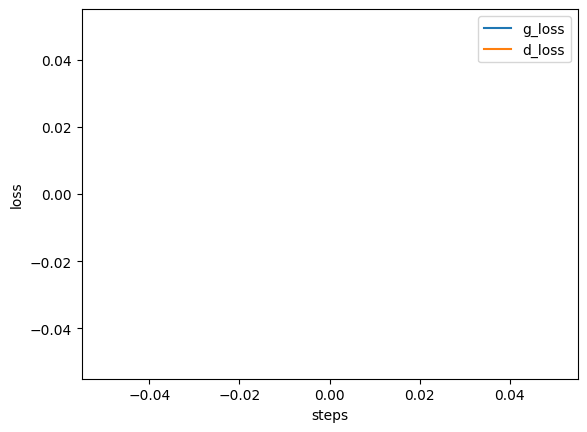

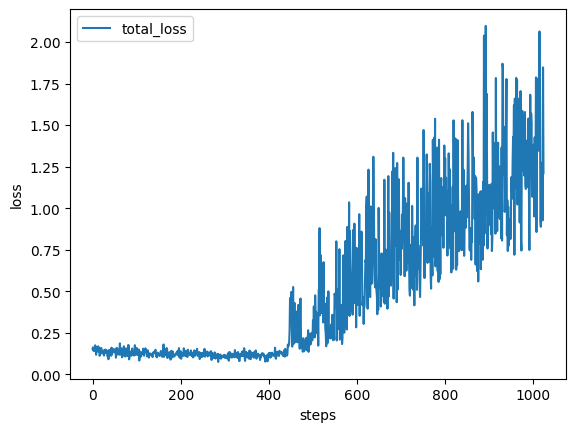

In [6]:
# train_loss.keys()
f=plt.figure()
plt.plot( range(len(train_loss['q_loss'])), train_loss['q_loss'], label='q_loss')
plt.xlabel('steps')
plt.ylabel('loss')
plt.legend()

f=plt.figure()
plt.plot( range(len(train_loss['rec_loss'])), train_loss['rec_loss'], label='rec_loss')
plt.xlabel('steps')
plt.ylabel('loss')
plt.legend()

f=plt.figure()
plt.plot( range(len(train_loss['perplexity'])), train_loss['perplexity'], label='perplexity')
plt.xlabel('steps')
plt.ylabel('loss')
plt.legend()


f=plt.figure()
plt.plot(range(len(train_loss['g_loss'])), train_loss['g_loss'], label='g_loss')
plt.plot(range(len(train_loss['d_loss'])), train_loss['d_loss'], label='d_loss')
plt.xlabel('steps')
plt.ylabel('loss')
plt.legend()

f=plt.figure()
plt.plot(range(len(train_loss['total_loss'])), train_loss['total_loss'], label='total_loss')
plt.xlabel('steps')
plt.ylabel('loss')
plt.legend()

# f=plt.figure()
# alpha = 0.8
# plt.plot(range(steps), train_loss['total_loss'], label='total_loss',alpha=alpha)
# plt.plot(range(steps), train_loss['g_loss'], label='g_loss',alpha=alpha)
# plt.plot(range(steps), train_loss['rec_loss'], label='rec_loss',alpha=alpha)
# plt.plot(range(steps), train_loss['vq_loss'], label='vq_loss',alpha=alpha)
# plt.xlabel('steps')
# plt.ylabel('loss')
# plt.legend()


#### Load the model - check image quanlity

In [2]:
# load pytorch model
import torch
from lpu3dnet.frame import vqgan

# get the global path
PATH = cfg.data.PATH.sub_vol

def get_img_list(idx_list,ct_idx):
    # input: ct image idx
    # output: list of images
    img_list = []
    for idx in idx_list:
        img = tif_to_np(f'{PATH}/ct_{ct_idx}/{idx}.tif')
        img_list.append(img)
    return img_list

def img_list_to_np(img_list):
    # input: list of images
    # output: numpy array of images
    image = np.stack(img_list,axis=0)
    return image

def idx_to_matrix(ct_idx,img_idx_list):
    # input: ct image idx, list of image idx
    # output: numpy array of images
    img_list = get_img_list(img_idx_list,ct_idx)
    img_matrix = img_list_to_np(img_list)
    img_matrix = img_matrix[:,np.newaxis,...]
    img_tensor = torch.from_numpy(img_matrix).float()

    return img_tensor,img_matrix


def tensor_to_np(tensor):
    # input: tensor
    # output: numpy array
    return tensor.detach().numpy()

root_path = os.path.join(cfg.checkpoints.PATH, cfg.experiment)
epoch = -1

model_vqgan = vqgan.VQGAN(cfg)
PATH_model = os.path.join(root_path,f'vqgan_epoch_{epoch}.pth')
model_vqgan.load_state_dict(
    torch.load(
            PATH_model,
            map_location=torch.device('cpu')
               )
    )

model_vqgan.eval()

VQGAN(
  (encoder): Encoder(
    (model): Sequential(
      (0): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): ResidualBlock(
        (block): Sequential(
          (0): GroupNorm(
            (gn): GroupNorm(16, 16, eps=1e-06, affine=True)
          )
          (1): Swish()
          (2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (3): GroupNorm(
            (gn): GroupNorm(16, 16, eps=1e-06, affine=True)
          )
          (4): Swish()
          (5): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        )
      )
      (2): ResidualBlock(
        (block): Sequential(
          (0): GroupNorm(
            (gn): GroupNorm(16, 16, eps=1e-06, affine=True)
          )
          (1): Swish()
          (2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (3): GroupNorm(
            (gn): GroupNorm(16, 16, eps=1e-06, affine=True)
          )
  

In [7]:
for key, para in model_vqgan.codebook.named_parameters():
    print(para[0:2,0:2])

tensor([[-0.1281, -0.0603],
        [-0.0015,  0.0007]], grad_fn=<SliceBackward0>)


In [3]:
# training idx is [2,3,4,5]
# 0 or 1 can be good for validation
ct_idx = 0

img_idx = [0,100,200,300,400,500]

img_tensor,img_matrix = idx_to_matrix(ct_idx,img_idx)

with torch.no_grad():
    decode_img,codebook_indice,_ = model_vqgan(img_tensor)
decode_img = tensor_to_np(decode_img)

# with torch.no_grad():
#     z = model_vqgan.encode(img_tensor)
#     decode_img = model_vqgan.decode(z)
# decode_img = tensor_to_np(decode_img)

In [4]:
def compare_images(generated_images, original_images):
    """
    Display a comparison of generated images to original images
    :param generated_images: numpy array of shape (n, 1, 64, 64, 64)
    :param original_images: numpy array of shape (n, 1, 64, 64, 64)
    """
    
    # Ensure the shapes of the two image arrays are the same
    assert generated_images.shape == original_images.shape, "The generated images and original images should have the same shape."

    n = generated_images.shape[0]  # number of images
    
    # Create a figure
    fig, axes = plt.subplots(n, 2, figsize=(10, 5 * n))
    
    for i in range(n):
        # For single row subplot adjustment
        if n == 1:
            ax_gen = axes[0]
            ax_orig = axes[1]
        else:
            ax_gen = axes[i, 0]
            ax_orig = axes[i, 1]

        # Display generated image
        ax_gen.imshow(generated_images[i,0,0,::], cmap='gray')
        ax_gen.set_title(f'Generated Image {i+1}')
        ax_gen.axis('off')

        # Display original image
        ax_orig.imshow(original_images[i,0,0,::], cmap='gray')
        ax_orig.set_title(f'Original Image {i+1}')
        ax_orig.axis('off')
    
    plt.tight_layout()
    plt.show()

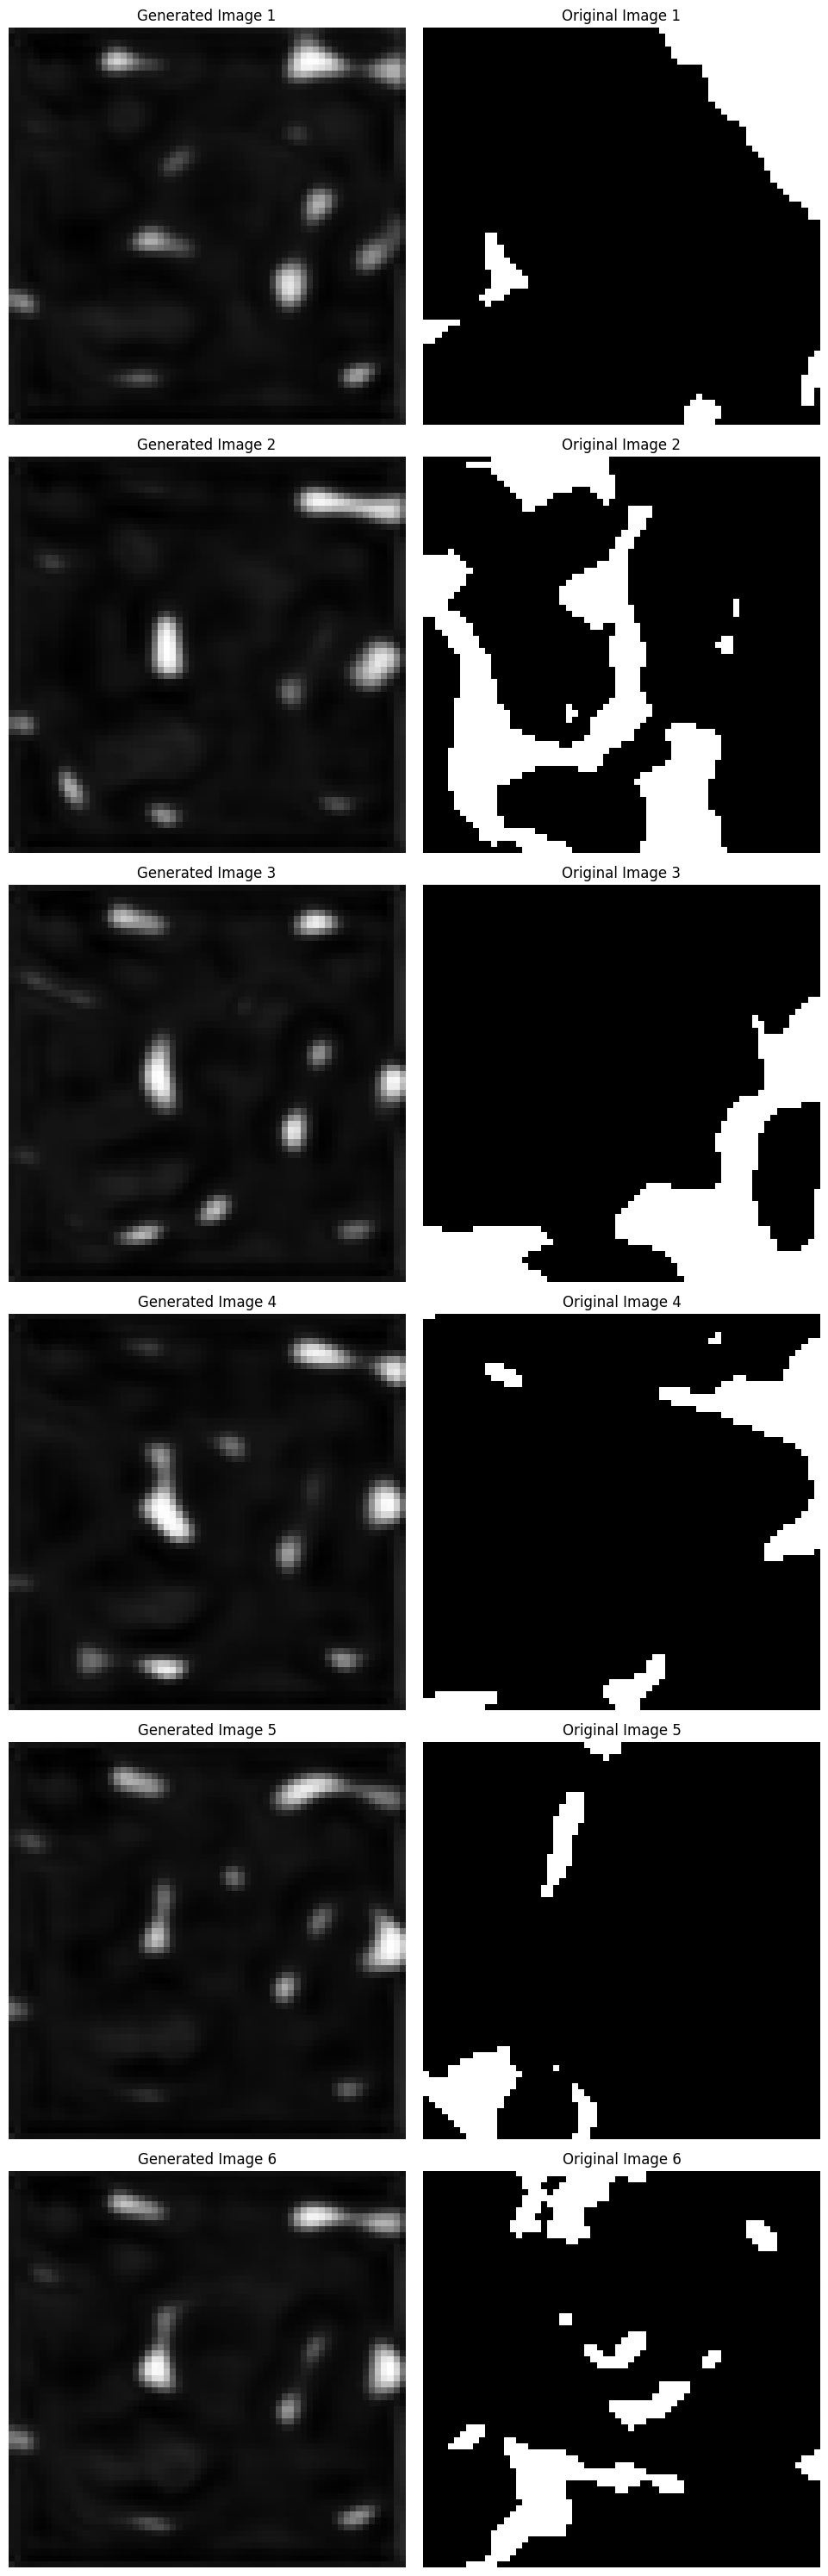

In [5]:
compare_images(decode_img,img_matrix)